In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
import pysindy as ps

# Ignore matplotlib deprecation warnings
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

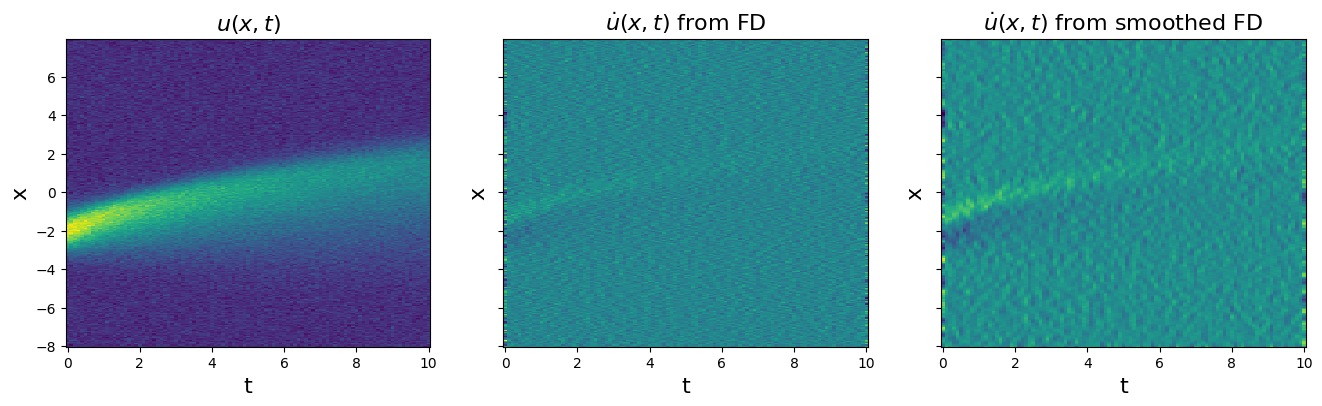

In [2]:
data = loadmat("data/burgers.mat")
time = np.ravel(data["t"])
x = np.ravel(data["x"])
u = np.real(data["usol"])
dt = time[1] - time[0]
dx = x[1] - x[0]
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
# add 20% noise (note the impact on derivatives depends on step size...)
u = u + np.random.normal(0, rmse / 5.0, u.shape)

# Plot u and u_dot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.pcolormesh(time, x, u)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)

u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 2)
plt.pcolormesh(time, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from FD", fontsize=16)

u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 3)
plt.pcolormesh(time, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from smoothed FD", fontsize=16)
plt.show()
# See how much SmoothedFiniteDifference improves the derivatives!

u = np.reshape(u, (len(x), len(time), 1))

We can follow the general recipe of weak SINDy:

In [9]:
# Define weak form PDE library
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

# Need to define the 2D spatiotemporal grid before calling the library
X, T = np.meshgrid(x, time)
XT = np.asarray([X, T]).T
np.random.seed(100) # for reproducibility because weak sindy samples randomly
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=1000,
)

# Fit a weak form model
#optimizer = ps.SR3(threshold=0.1, thresholder="l0", tol=1e-8, normalize_columns=True, max_iter=1000)
optimizer = ps.STLSQ(threshold=.1, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
print(f"{u.shape = }, {XT.shape = }")
model.fit(u)
model.print()
model.score(u)

u.shape = (256, 101, 1), XT.shape = (256, 101, 2)
(x0)' = 0.098 x0_11 + -1.009 x0x0_1


0.8504191070934939

Alternatively we can gain more control by using individual functions of weak SINDy library:

In [13]:
# Define weak form PDE library
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

# Need to define the 2D spatiotemporal grid before calling the library
Lx = np.max(x) - np.min(x)
Lt = np.max(time) - np.min(time)
X, T = np.meshgrid(x, time)
XT = np.asarray([X, T]).T
np.random.seed(100)
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XT,
    H_xt = [Lx/20, Lt/20],
    is_uniform=True,
    K=1000,
)

pde_lib.fit(u)
print(f"{u.shape = }")
U = pde_lib.transform(u) # converts it to features corresponding to different r.h.s. terms sampled at K points
print(f"{U.shape = }, features: {pde_lib.get_feature_names()}")
U_dot = pde_lib.convert_u_dot_integral(u) # but we also have to compute the time derivative
print(f"{U_dot.shape = }")
optimizer = ps.STLSQ(threshold=.1, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=ps.PolynomialLibrary(degree=1), feature_names=pde_lib.get_feature_names(), optimizer=optimizer)
model.fit(U, x_dot=U_dot)
model.print()
model.score(U, x_dot=U_dot)

u.shape = (256, 101, 1)
U.shape = (1000, 8), features: ['x0', 'x0x0', 'x0_1', 'x0_11', 'x0x0_1', 'x0x0x0_1', 'x0x0_11', 'x0x0x0_11']
U_dot.shape = (1000, 1)
(x0)' = 0.098 x0_11 + -1.009 x0x0_1


0.8504191070934939

In principle this gives us the ability to overwrite the `U_dot` which is very useful. In addition, this allows us to use standard SINDy libraries which are compatible with `GridSearch` for example

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
# Define weak form PDE library
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

# Need to define the 2D spatiotemporal grid before calling the library
X, T = np.meshgrid(x, time)
XT = np.asarray([X, T]).T
np.random.seed(100)
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=1000, # unfortunately the kwargs of `WeakPDELibrary` must be predetermined and cannot be passed to `fit` when doing cross-validation. There is a way to do it but it's a bit more involved.
)

pde_lib.fit(u)
U = pde_lib.transform(u)
U_dot = pde_lib.convert_u_dot_integral(u)
optimizer = ps.STLSQ(threshold=.1, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=ps.PolynomialLibrary(degree=1), feature_names=pde_lib.get_feature_names(), optimizer=optimizer)
param_grid = {
    "optimizer__threshold": [0.001, 0.01, 0.05, 0.1, 0.2],
    "optimizer__alpha": [1e-5,1e-4,1e-3,1e-2, 0.05, 0.1, 1]
}
search = GridSearchCV(
    model,
    param_grid,
    cv=TimeSeriesSplit(n_splits=5)
)

search.fit(U, x_dot=U_dot)
print("Best parameters:", search.best_params_)
search.best_estimator_.print()
search.best_estimator_.score(U, x_dot=U_dot)

Best parameters: {'optimizer__alpha': 1e-05, 'optimizer__threshold': 0.001}
(x0)' = 0.001 1 + 0.022 x0 + -0.059 x0x0 + -0.065 x0_1 + 0.076 x0_11 + -0.585 x0x0_1 + -0.532 x0x0x0_1 + 0.014 x0x0_11 + 0.014 x0x0x0_11


0.8558015994622244

The method sacrifices parsimony so to be able to use it effectively one would have to redefine the score for the grid search to be some BIC type score. Or even simpler some measure or r2_core minus number of terms for example

If we want to only work spatial components, however, this would be complicated since `WeakPDELibrary` is conceived to work with space-time. Notice that it automatically integrates over temporal slices which could be a problem if you don't have enough samples in time. However, it is possible to use just `PDELibrary` in this case:

In [18]:
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=x,
    include_bias=False,
    is_uniform=True,
)

# Fit and predict with the non-weak model
opt = ps.STLSQ(threshold=.1, alpha=1e-5, normalize_columns=True)
model_for_prediction = ps.SINDy(feature_library=pde_lib, optimizer=opt)
model_for_prediction.fit(u)

# Prints a very wrong model
model_for_prediction.print()
model_for_prediction.score(u)

(x0)' = 0.011 x0 + -0.031 x0x0 + -0.001 x0_1 + -0.012 x0x0_1 + -0.028 x0x0x0_1


0.014777239877762471

In [20]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=x,
    include_bias=False,
    is_uniform=True,
)
u_dot = ps.FiniteDifference(axis=-2)._differentiate(u, t=dt)
# Fit and predict with the non-weak model
opt = ps.STLSQ(threshold=.1, alpha=1e-5, normalize_columns=True)
model_for_prediction = ps.SINDy(feature_library=pde_lib, optimizer=opt)
model_for_prediction.fit(u, x_dot=u_dot)

# Prints a very wrong model
model_for_prediction.print()
print(u_dot.shape)
model_for_prediction.score(u, x_dot=u_dot)

(x0)' = 0.108 x0 + -0.313 x0x0 + -0.012 x0_1 + -0.117 x0x0_1 + -0.278 x0x0x0_1 + -0.004 x0x0_11 + 0.005 x0x0x0_11
(256, 101, 1)


0.01477723987776236

Below we show that regular `PDELibrary` can be used to extract derivatives at any time slice

In [26]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=x,
    include_bias=False,
    is_uniform=True,
)
pde_lib.fit(u)
U = pde_lib.transform(u)
U.shape, pde_lib.get_feature_names()

((256, 101, 8),
 ['x0', 'x0x0', 'x0_1', 'x0_11', 'x0x0_1', 'x0x0x0_1', 'x0x0_11', 'x0x0x0_11'])

In [27]:
print(U[:20,0,0])

[-0.07369746 -0.04785759  0.02493512  0.14043158 -0.04505272 -0.05812832
  0.00573069  0.0790624   0.05321859  0.02652179  0.00112516 -0.04546475
  0.01898545 -0.02576097  0.03081234 -0.02309278 -0.09713292  0.0107125
 -0.04891985  0.10842886]


In [28]:
pde_lib.fit(u[:,0:1,:])
U = pde_lib.transform(u[:,0:1,:])
U.shape, pde_lib.get_feature_names()

((256, 1, 8),
 ['x0', 'x0x0', 'x0_1', 'x0_11', 'x0x0_1', 'x0x0x0_1', 'x0x0_11', 'x0x0x0_11'])

In [29]:
print(U[:20,0,0])

[-0.07369746 -0.04785759  0.02493512  0.14043158 -0.04505272 -0.05812832
  0.00573069  0.0790624   0.05321859  0.02652179  0.00112516 -0.04546475
  0.01898545 -0.02576097  0.03081234 -0.02309278 -0.09713292  0.0107125
 -0.04891985  0.10842886]


In [30]:
u.shape

(256, 101, 1)

In [13]:
v = np.concatenate([u,u],axis=2)
v.shape

(256, 101, 2)

In [16]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=1,
    spatial_grid=x,
    include_bias=False,
    is_uniform=True,
)
pde_lib.fit(v)
V = pde_lib.transform(v)
V.shape, pde_lib.get_feature_names()

((256, 101, 14),
 ['x0',
  'x1',
  'x0x0',
  'x1x1',
  'x0_1',
  'x1_1',
  'x0x0_1',
  'x1x0_1',
  'x0x0x0_1',
  'x1x1x0_1',
  'x0x1_1',
  'x1x1_1',
  'x0x0x1_1',
  'x1x1x1_1'])

In [43]:
library_functions = [lambda x: x, lambda x: x * x, lambda x, y: x * y]
library_function_names = [lambda x: x, lambda x: x + x, lambda x, y : x + y]

pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=1,
    spatial_grid=x,
    include_bias=False,
    is_uniform=True,
)
pde_lib.fit(v)
V = pde_lib.transform(v)
V.shape, pde_lib.get_feature_names()

((256, 101, 17),
 ['x0',
  'x1',
  'x0x0',
  'x1x1',
  'x0x1',
  'x0_1',
  'x1_1',
  'x0x0_1',
  'x1x0_1',
  'x0x0x0_1',
  'x1x1x0_1',
  'x0x1x0_1',
  'x0x1_1',
  'x1x1_1',
  'x0x0x1_1',
  'x1x1x1_1',
  'x0x1x1_1'])

We can try solving a mock identification problem where the goal is to identify $V = U_x + U_y$

In [71]:
x = np.arange(0, 1, 0.01)
y = np.arange(0, 1, 0.01)
t = np.arange(0, 1 ,0.01)
X, Y, T = np.meshgrid(x, y, t, indexing='ij')
U = np.cos(X) + np.cos(2*X) +np.sin(3*Y) + np.random.normal(0, .001, X.shape)
V = - np.sin(X) - 2*np.sin(2*X) + 3*np.cos(3*Y) + np.random.normal(0, .001, X.shape)    # V = U_x + U_y
U = U[...,np.newaxis]
V = V[...,np.newaxis]
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
X, Y = np.meshgrid(x, y)
spatial_grid = np.asarray([X, Y]).T
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=1,
    spatial_grid=spatial_grid,
    include_bias=False,
    is_uniform=True,
)

# Fit and predict with the non-weak model
opt = ps.STLSQ(threshold=.1, alpha=1e-5, normalize_columns=False)
model_for_prediction = ps.SINDy(feature_library=pde_lib, optimizer=opt)
model_for_prediction.fit(U, x_dot=V)
model_for_prediction.print()

(x0)' = 0.999 x0_2 + 0.998 x0_1


This works ok unless we add a small amount of noise:

In [60]:
x = np.arange(0, 1, 0.01)
y = np.arange(0, 1, 0.01)
t = np.arange(0, 1 ,0.01)
X, Y, T = np.meshgrid(x, y, t, indexing='ij')
U = np.cos(X) + np.cos(2*X) +np.sin(3*Y) + np.random.normal(0, .01, X.shape)
V = - np.sin(X) - 2*np.sin(2*X) + 3*np.cos(3*Y) + np.random.normal(0, .01, X.shape)    # V = U_x + U_y
U = U[...,np.newaxis]
V = V[...,np.newaxis]
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
X, Y = np.meshgrid(x, y)
spatial_grid = np.asarray([X, Y]).T
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=1,
    spatial_grid=spatial_grid,
    include_bias=False,
    is_uniform=True,
)

# Fit and predict with the non-weak model
opt = ps.STLSQ(threshold=.1, alpha=1e-5, normalize_columns=False)
model_for_prediction = ps.SINDy(feature_library=pde_lib, optimizer=opt)
model_for_prediction.fit(U, x_dot=V)
model_for_prediction.print()

(x0)' = -1.994 x0 + 0.644 x0x0 + 0.881 x0_2 + 0.555 x0_1 + -0.112 x0x0_1


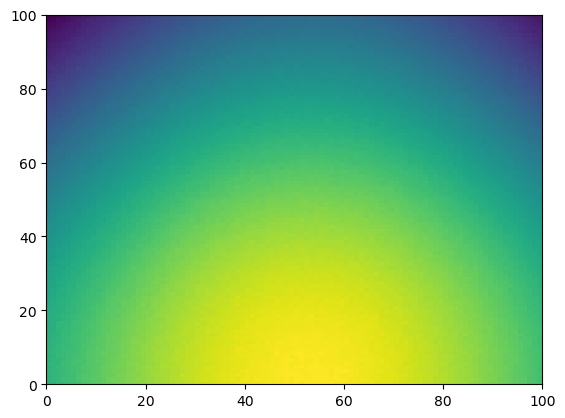

In [63]:
plt.pcolormesh(U[...,0,0])